# CANDLES NLP Classification

<img src="img/word_cloud.png" width="800"/>

# Project Goals
> - Predict language based on README file of trending repos on GitHub
> - Build a ML model that can beat our baseline in predicting language
> - Produce a documented notebook, 2 slide presentation, and 5 minute video presentation


# Executive Summary
> - Identified 7 Coding Languages (C, C++, Go, Java, JavaScript, Python, Swift)
> - Baseline Accuracy of 13.5%
> - Modeled KNN, Logistic Regression, Naive Bayes, and Random Forest using vectorization
> - Best Model: Random Forest with depth = 20 had an accuracy of  77.5%


In [2]:
# imports
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import eli5

from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

import requests
from bs4 import BeautifulSoup 
import re
from src import prepare, acquire

plt.style.use('classic')

# Carolyn
import nltk
import unicodedata
import json

# steven
# from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV


# Acquire & Prep

In [ ]:
# acquire function to scrape github data and create trending.csv
acquire.repo_df()

https://github.com/search?q=candles&type=Repositories

In [8]:
# reads trending.csv
df = pd.read_csv('data/trending.csv')

In [5]:
# prepares data and creates "processed.csv"
df = prepare.process_readmes(df.readme)

# Explore

In [9]:
# getting the data 
df = pd.read_csv('data/processed.csv')

In [10]:
df.head() # check dataframe head

,repo,language,readme,words,lang_freq
0,/apple/swift,C++,img src https swift org asset imag swift svg a...,1260,100
1,/openalpr/openalpr,C++,openalpr openalpr open sourc automat licens pl...,622,100
2,/tensorflow/tensorflow,C++,div align center img src https www tensorflow ...,1216,100
3,/wjakob/pybind11,C++,pybind logo https github com pybind pybind raw...,610,100
4,/Polytonic/Chlorine,C++,chlorin http polyton github io chlorin build s...,624,100


In [11]:
# grouping the data by the language column values
df.groupby('language').sum()

,words,lang_freq
language,,
C,77923,8836
C++,88730,10000
Go,98088,11236
Java,51615,10404
JavaScript,124578,9409
Python,107661,10404
Swift,141670,10000


In [12]:
# getting the number count of each language in the data
df.language.value_counts()

Go            106
Python        102
Java          102
C++           100
Swift         100
JavaScript     97
C              94
Name: language, dtype: int64

In [17]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [18]:
# breaking up the data into the separate languages 
go = clean(' '.join(df[df.language == 'Go'].language))
java = clean(' '.join(df[df.language == 'Java'].language))
python = clean(' '.join(df[df.language == 'Python'].language))
C_plus_plus = clean(' '.join(df[df.language == 'C++'].language))
Swift = clean(' '.join(df[df.language == 'Swift'].language))
javascript = clean(' '.join(df[df.language == 'JavaScript'].language))
c = clean(' '.join(df[df.language == 'C'].language))
all_languages = clean(' '.join(df.language))

In [19]:
# transforming the data into a pandas series
go_freq = pd.Series(go).value_counts()
java_freq = pd.Series(java).value_counts()
python_freq = pd.Series(python).value_counts()
c_plus_plus_freq = pd.Series(C_plus_plus).value_counts()
Swift_freq = pd.Series(Swift).value_counts()
javascript_freq = pd.Series(javascript).value_counts()
c_script = pd.Series(c).value_counts()

all_freq = pd.Series(all_languages).value_counts()

java_freq.head()

java    102
dtype: int64

In [20]:
# combining the languages into one dataframe
word_counts = (pd.concat([all_freq, go_freq, java_freq, python_freq, c_plus_plus_freq, Swift_freq, javascript_freq, c_script], axis=1, sort=True)
                .set_axis(['all', 'go', 'java', 'python', 'c++', 'swift', 'js', 'c'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,go,java,python,c++,swift,js,c
c,194,0,0,0,100,0,0,94
go,106,106,0,0,0,0,0,0
java,102,0,102,0,0,0,0,0
javascript,97,0,0,0,0,0,97,0
python,102,0,0,102,0,0,0,0


In [21]:
# sorting the dataframe by most frequently occuring
# the c row counted both 'c' and 'c++' languages
word_counts.sort_values(by='all', ascending=False).head(10)

,all,go,java,python,c++,swift,js,c
c,194,0,0,0,100,0,0,94
go,106,106,0,0,0,0,0,0
java,102,0,102,0,0,0,0,0
python,102,0,0,102,0,0,0,0
swift,100,0,0,0,0,100,0,0
javascript,97,0,0,0,0,0,97,0


# Visualization

Text(0.5, 1.0, 'Proportion of Coding Languages')

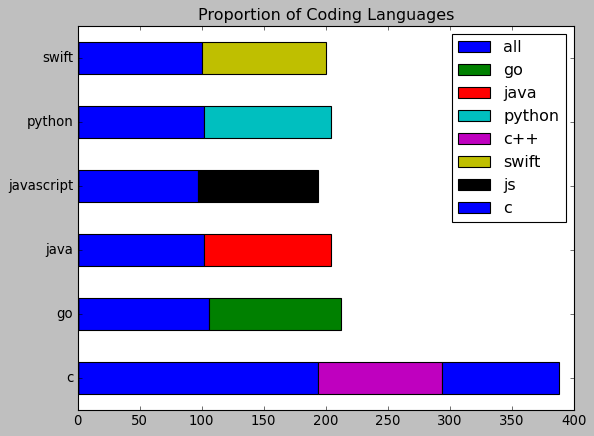

In [22]:
# barh plot of the proportion of coding languages
word_counts.plot.barh(stacked=True)
plt.title('Proportion of Coding Languages')

In [23]:
# imports for wordclouds
from wordcloud import WordCloud

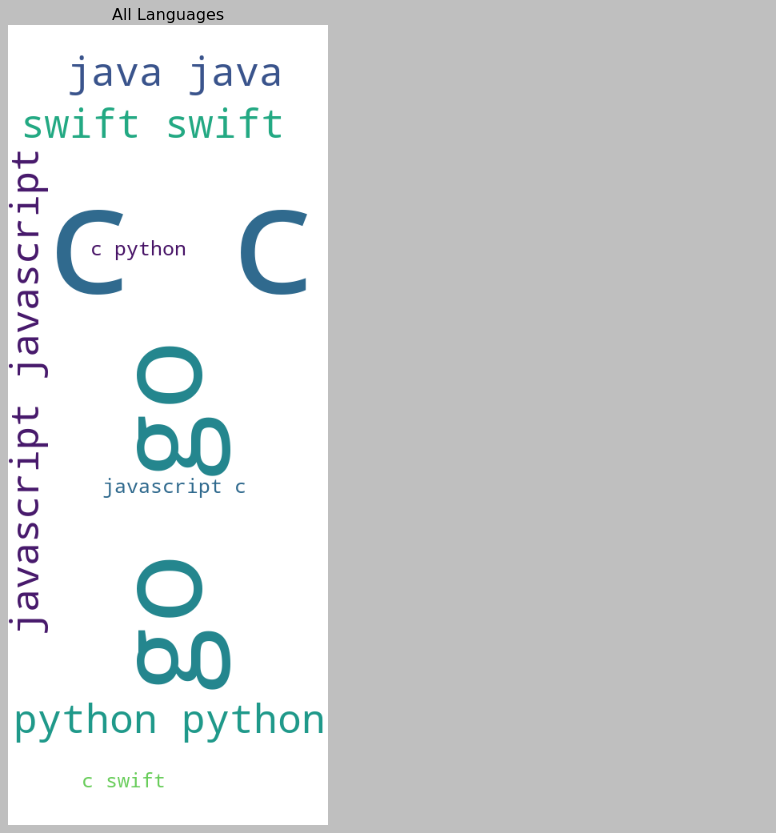

In [24]:
# creating a word cloud for all the languages
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_languages))

plt.figure(figsize=(10, 10))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)

axs[0].set_title('All Languages')

for ax in axs: ax.axis('off')

(-0.5, 1599.5, 799.5, -0.5)

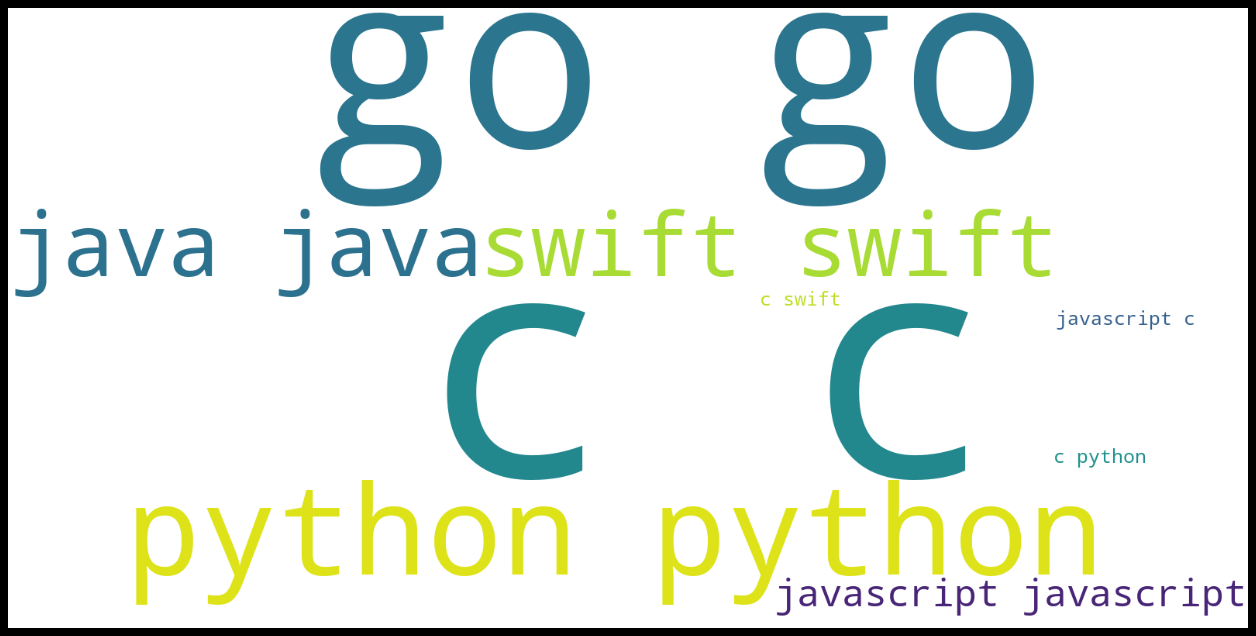

In [25]:
# another wordcloud of all the languages
wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(all_languages))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")

<AxesSubplot:ylabel='language'>

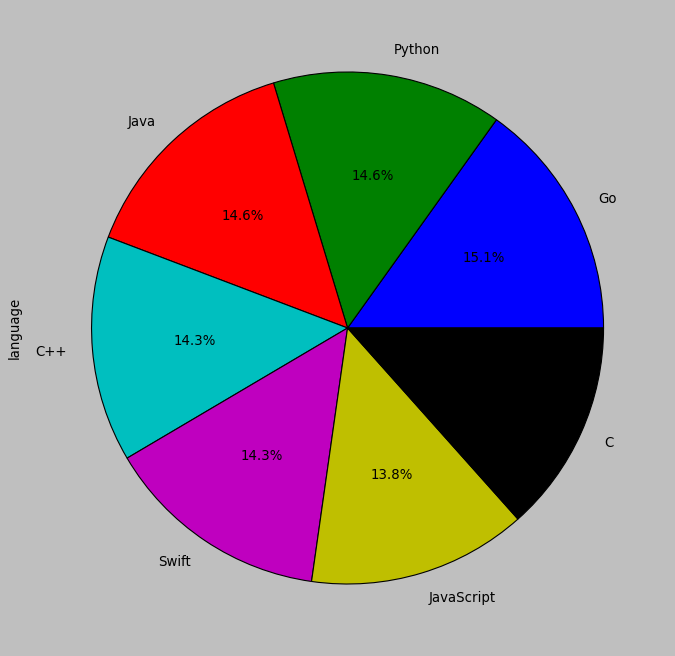

In [26]:
# making a pie chart of all the languages
plt.figure(figsize=(20,10))
df['language'].value_counts().head(10).plot.pie(autopct='%1.1f%%')

Text(0.5, 1.0, 'Scatterplot of Languages and Word Counts')

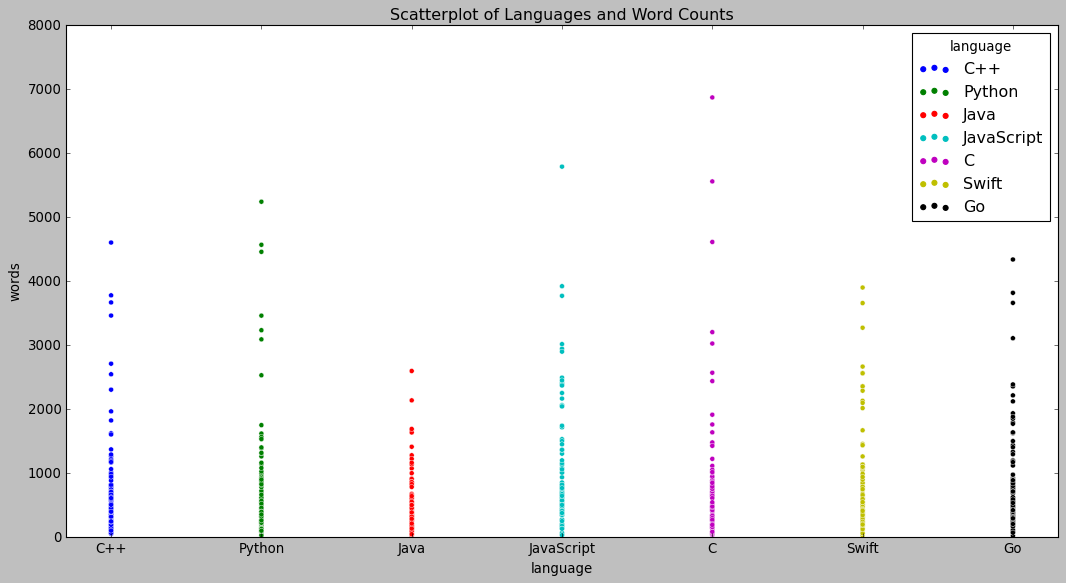

In [27]:
# scatterplot of all the languages
plt.figure(figsize=(16,8))
sns.scatterplot(x='language',y='words',data=df, hue='language')
## Set axis limits
plt.ylim(0,8000)

plt.title('Scatterplot of Languages and Word Counts')

# More Exploration...

In [28]:
df = pd.read_csv('data/processed.csv')

In [29]:
#data is cleaned 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   repo       701 non-null    object
 1   language   701 non-null    object
 2   readme     701 non-null    object
 3   words      701 non-null    int64 
 4   lang_freq  701 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 27.5+ KB


In [30]:
df.language.value_counts()

Go            106
Python        102
Java          102
C++           100
Swift         100
JavaScript     97
C              94
Name: language, dtype: int64

In [40]:
# import plotly.express as px

# fig = px.histogram(df, x='lang_freq', template='plotly_white', title='readme counts by language')
# fig.update_xaxes(categoryorder='total descending').update_yaxes(title='Number of readme counts')
# fig.show()

read_me_df = df[['readme', 'language']].copy()

In [41]:
#how many language observations do we have?
read_me_df.language.value_counts(normalize = True)

Go            0.151213
Python        0.145506
Java          0.145506
C++           0.142653
Swift         0.142653
JavaScript    0.138374
C             0.134094
Name: language, dtype: float64

In [42]:
read_me_df['language'].value_counts()
# Go            106
# Python        102
# Java          102
# Swift         100
# C++           100
# JavaScript     97
# C              94

Go            106
Python        102
Java          102
C++           100
Swift         100
JavaScript     97
C              94
Name: language, dtype: int64

In [43]:
# combine all readmes in single string by language
def clean(language):
    '''Simplified text cleaning function'''
    language = language.lower()
    language = unicodedata.normalize('NFKD', language).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return re.sub(r"[^a-z0-9\s]", '', language)

In [44]:
go_words = clean(' '.join(read_me_df[read_me_df.language == 'Go'].readme))
python_words = clean(' '.join(read_me_df[read_me_df.language == 'Python'].readme))
java_words = clean(' '.join(read_me_df[read_me_df.language == 'Java'].readme))
cplus_plus_words = clean(' '.join(read_me_df[read_me_df.language == 'C++'].readme))
javascript_words = clean(' '.join(read_me_df[read_me_df.language == 'JavaScript'].readme))
swift_words = clean(' '.join(read_me_df[read_me_df.language == 'Swift'].readme))
c_words = clean(' '.join(read_me_df[read_me_df.language == 'C'].readme))

In [45]:
all_words = clean(' '.join(read_me_df.readme))

In [46]:
# Represent text as word frequencies.

go_freq = pd.Series(go_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
cplus_plus_freq = pd.Series(cplus_plus_words.split()).value_counts()
javascript_freq = pd.Series(javascript_words.split()).value_counts()
swift_freq = pd.Series(swift_words.split()).value_counts()
c_freq = pd.Series(c_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [47]:
pd.concat([go_freq, python_freq, java_freq, cplus_plus_freq, javascript_freq, swift_freq, c_freq, all_freq], axis = 1).fillna(0).astype(int)

,0,1,2,3,4,5,6,7
https,2311,2783,1286,2333,3955,6289,1463,20420
com,1976,1993,1577,1790,3041,6566,1219,18162
go,1461,151,19,81,41,58,58,1869
github,1302,1727,953,1296,1519,2748,822,10367
use,1151,1096,387,1017,1129,970,853,6603
...,...,...,...,...,...,...,...,...
iqsgtggo,0,0,0,0,0,0,1,1
tighter,0,0,0,0,0,0,1,1
devnat,0,0,0,0,0,0,1,1
externalnativebuild,0,0,0,0,0,0,1,1


In [48]:
# concat all frequencies together into a dataframe

word_counts = pd.concat([go_freq, python_freq, java_freq, cplus_plus_freq, javascript_freq, swift_freq, c_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['Go', 'Python', 'Java', 'C++', 'JavaScript', 'Swift', 'C', 'all']
word_counts.head()

,Go,Python,Java,C++,JavaScript,Swift,C,all
https,2311,2783,1286,2333,3955,6289,1463,20420
com,1976,1993,1577,1790,3041,6566,1219,18162
go,1461,151,19,81,41,58,58,1869
github,1302,1727,953,1296,1519,2748,822,10367
use,1151,1096,387,1017,1129,970,853,6603


In [49]:
# sort by 'all'

word_counts.sort_values('all', ascending=False).head(20)

,Go,Python,Java,C++,JavaScript,Swift,C,all
https,2311,2783,1286,2333,3955,6289,1463,20420
com,1976,1993,1577,1790,3041,6566,1219,18162
github,1302,1727,953,1296,1519,2748,822,10367
use,1151,1096,387,1017,1129,970,853,6603
http,725,556,496,420,476,1298,379,4350
href,182,18,87,120,851,2510,42,3810
imag,334,772,156,148,447,1407,225,3489
png,158,586,186,148,254,1944,137,3413
org,442,776,178,540,771,356,305,3368
io,497,388,223,301,521,1197,216,3343


Text(0.5, 1.0, 'Count by Language for the top 20 most frequent words')

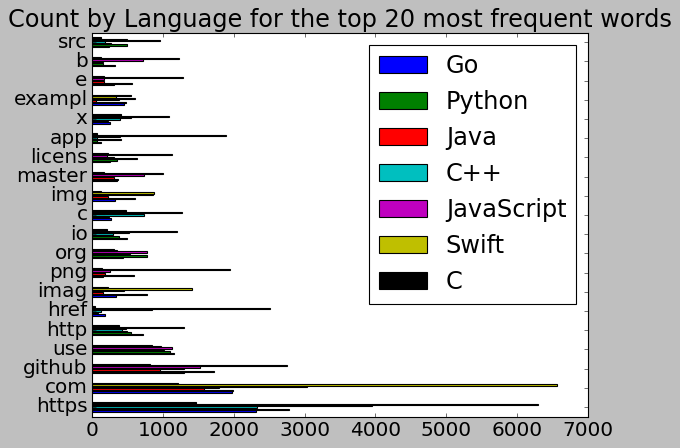

In [50]:
# word_counts.sort_values(['Go', 'Python', 'Java', 'C++', 'JavaScript', 'Swift', 'C'], ascending=[True, False]).head(20)


plt.rc('font', size=18)
word_counts.sort_values('all', ascending=False).head(20)[['Go', 'Python', 'Java', 'C++', 'JavaScript', 'Swift', 'C']].plot.barh()
plt.title('Count by Language for the top 20 most frequent words')

Text(0.5, 1.0, '% of Go vs all for the most common 20 words')

<Figure size 1280x720 with 0 Axes>

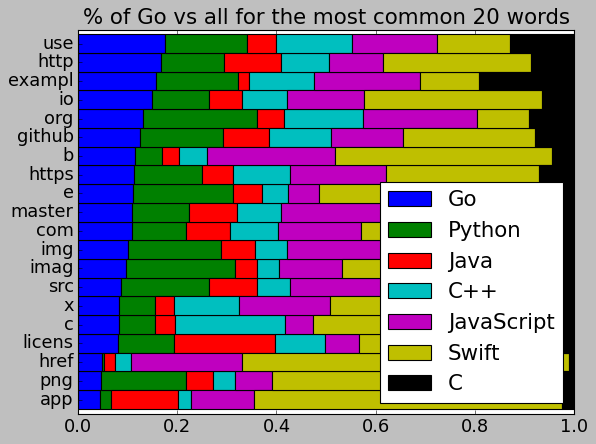

In [51]:
plt.figure(figsize=(16, 9))
plt.rc('font', size=16)

(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'Go')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.title('% of Go vs all for the most common 20 words')

# =============================================================================
# Looking at Bigrams
# =============================================================================

In [53]:
# =============================================================================
# #Go Bigrams
# =============================================================================
list(nltk.bigrams(go_words.split()))

[('metadata', 'absolut'),
 ('absolut', 'tell'),
 ('tell', 'everyth'),
 ('everyth', 'somebodi'),
 ('somebodi', 'life'),
 ('life', 'stewart'),
 ('stewart', 'baker'),
 ('baker', 'http'),
 ('http', 'www'),
 ('www', 'nybook'),
 ('nybook', 'com'),
 ('com', 'articl'),
 ('articl', 'archiv'),
 ('archiv', 'nov'),
 ('nov', 'snowden'),
 ('snowden', 'leak'),
 ('leak', 'public'),
 ('public', 'former'),
 ('former', 'general'),
 ('general', 'counsel'),
 ('counsel', 'nsa'),
 ('nsa', 'kill'),
 ('kill', 'peopl'),
 ('peopl', 'base'),
 ('base', 'metadata'),
 ('metadata', 'michael'),
 ('michael', 'hayden'),
 ('hayden', 'https'),
 ('https', 'www'),
 ('www', 'youtub'),
 ('youtub', 'com'),
 ('com', 'watch'),
 ('watch', 'v'),
 ('v', 'kv'),
 ('kv', 'hdm'),
 ('hdm', 'xgi'),
 ('xgi', 'former'),
 ('former', 'director'),
 ('director', 'nsa'),
 ('nsa', 'vuvuzela'),
 ('vuvuzela', 'vuvuzela'),
 ('vuvuzela', 'messag'),
 ('messag', 'system'),
 ('system', 'protect'),
 ('protect', 'privaci'),
 ('privaci', 'messag'),
 ('mes

Text(0.5, 1.0, 'Top 10 most common Go bigrams')

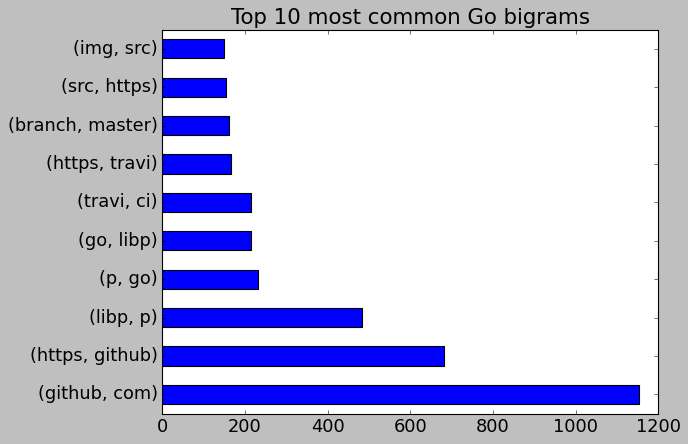

In [54]:
# what are the most common bigrams? by language bigrams? 
# visualize 20 most common bigrams, most common by language bigrams
# ngrams

# Find the most common bigram and then find a representative text

pd.Series(nltk.bigrams(go_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common Go bigrams')

Text(0.5, 1.0, 'Top 10 most common Python bigrams')

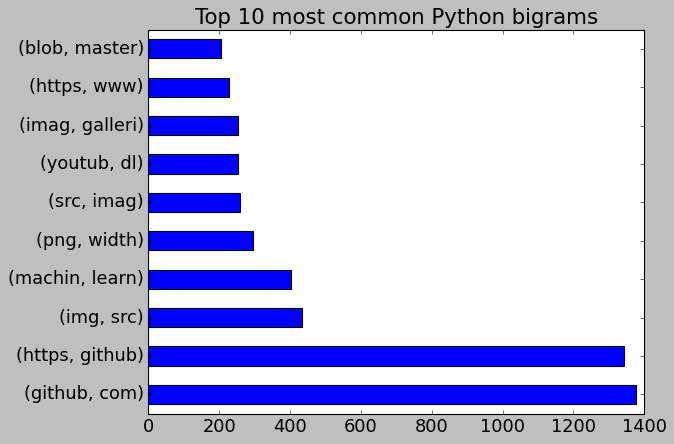

In [55]:
# =============================================================================
# Python Birgrams
# =============================================================================
pd.Series(nltk.bigrams(python_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common Python bigrams')

Text(0.5, 1.0, 'Top 10 most common Java bigrams')

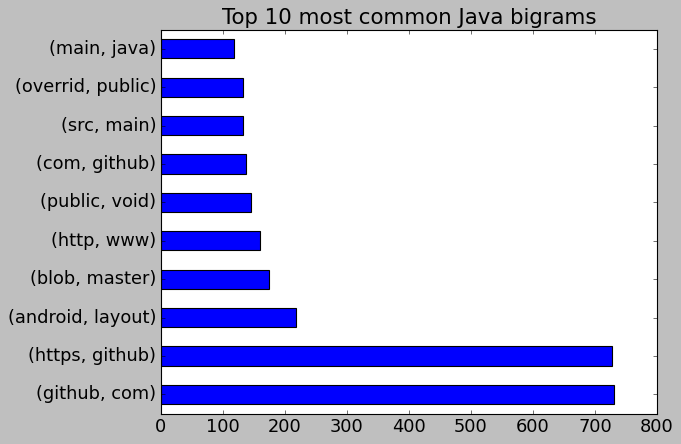

In [56]:
# =============================================================================
# Java Bigrams
# =============================================================================
pd.Series(nltk.bigrams(java_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common Java bigrams')

Text(0.5, 1.0, 'Top 10 most common C++ bigrams')

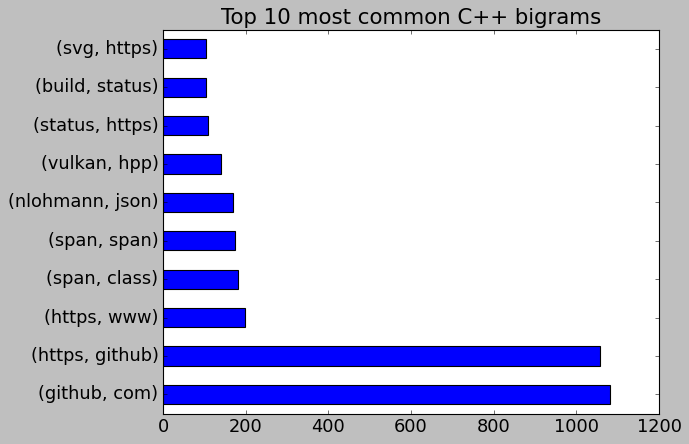

In [57]:
# =============================================================================
# C++ Bigrams
# =============================================================================
pd.Series(nltk.bigrams(cplus_plus_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common C++ bigrams')

Text(0.5, 1.0, 'Top 10 most common Javascript bigrams')

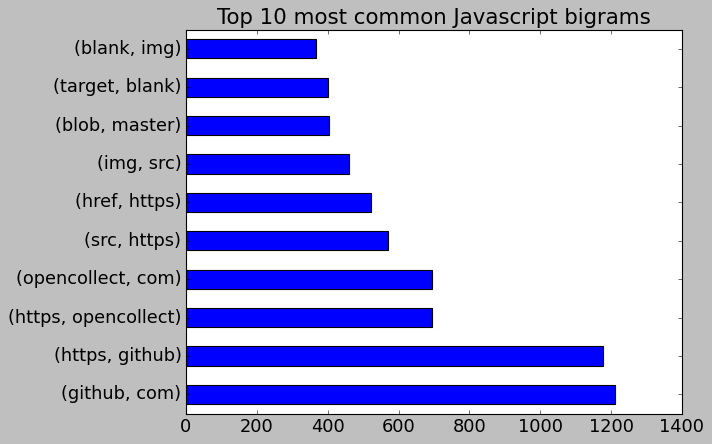

In [58]:
# =============================================================================
# Javascript Bigrams
# =============================================================================
pd.Series(nltk.bigrams(javascript_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common Javascript bigrams')

Text(0.5, 1.0, 'Top 10 most common Swift bigrams')

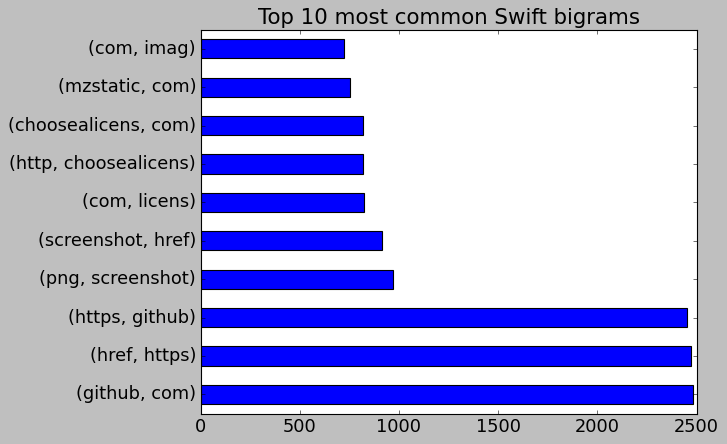

In [59]:
# =============================================================================
# Swift Bigrams
# =============================================================================
pd.Series(nltk.bigrams(swift_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common Swift bigrams')

Text(0.5, 1.0, 'Top 10 most common C bigrams')

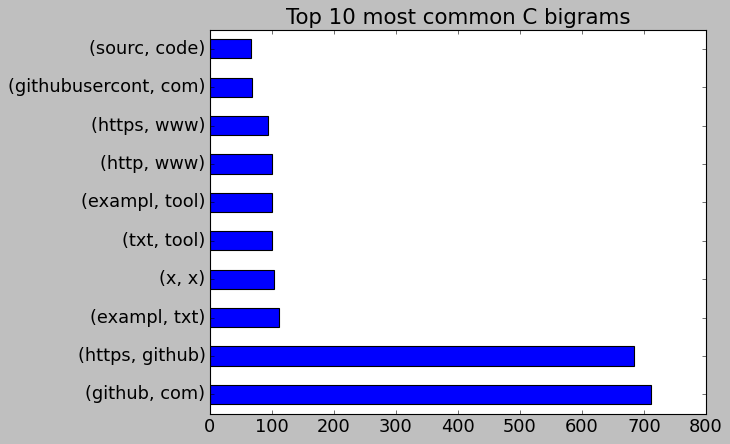

In [60]:
# =============================================================================
# C Bigrams
# =============================================================================
pd.Series(nltk.bigrams(c_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common C bigrams')

Text(0.5, 1.0, 'Top 10 most common bigrams from all words')

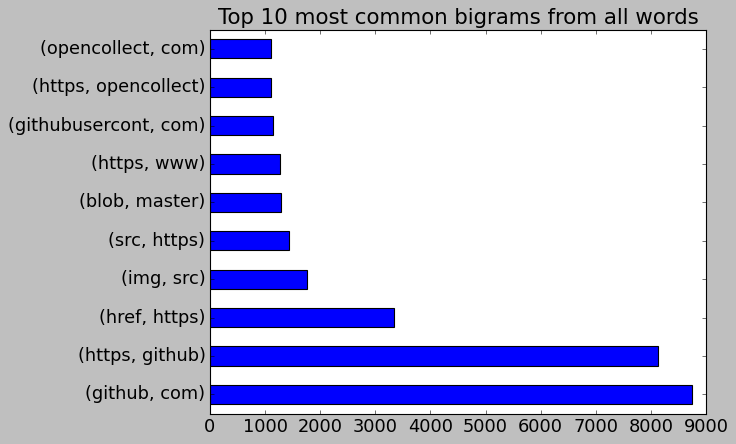

In [61]:
# =============================================================================
# All Bigrams
# =============================================================================
pd.Series(nltk.bigrams(all_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common bigrams from all words')

# Even More Exploration

In [2]:
df = pd.read_csv('data/processed.csv')

In [3]:
df.head()

,repo,language,readme,words,lang_freq
0,/apple/swift,C++,img src https swift org asset imag swift svg a...,1260,100
1,/openalpr/openalpr,C++,openalpr openalpr open sourc automat licens pl...,622,100
2,/tensorflow/tensorflow,C++,div align center img src https www tensorflow ...,1216,100
3,/wjakob/pybind11,C++,pybind logo https github com pybind pybind raw...,610,100
4,/Polytonic/Chlorine,C++,chlorin http polyton github io chlorin build s...,624,100


# Bag of Words

In [4]:
cv = CountVectorizer()
bag_of_words = cv.fit_transform(df.readme)

In [5]:
bag_of_words.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [6]:
cv.get_feature_names()

['aa',
 'aaa',
 'aaaa',
 'aaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaa',
 'aaaaaaaacn',
 'aaaaaavvvvvxxxxxtttt',
 'aaaab',
 'aaaabbbbcccc',
 'aaaacc',
 'aaaaoooooo',
 'aaabf',
 'aaad',
 'aaaffaaaa',
 'aab',
 'aabc',
 'aabqxjyv',
 'aac',
 'aacaf',
 'aacanakin',
 'aacb',
 'aaccess',
 'aacigyxew',
 'aad',
 'aadadd',
 'aadc',
 'aadvic',
 'aae',
 'aaf',
 'aafb',
 'aaff',
 'aagtorr',
 'aagxjzrqm',
 'aah',
 'aalen',
 'aan',
 'aandroid',
 'aanze',
 'aap',
 'aapcmdackhlfobmkcpplkjpfceihngkh',
 'aapl',
 'aaplhn',
 'aaqobk',
 'aar',
 'aarch',
 'aaron',
 'aarono',
 'aaronpearc',
 'aaronrandal',
 'aaronsw',
 'aaronvb',
 'aarsaeth',
 'aas',
 'ab',
 'aba',
 'ababc',
 'abacus',
 'abandon',
 'abb',
 'abbaswasim',
 'abbba',
 'abbc',
 'abber',
 'abbr',
 'abbrev',
 'abbrevi',
 'abc',
 'abd',
 'abdol',
 'abe',
 'abeginn',
 'abeiv',
 'abel',
 'abelhadigit',
 'aberr',
 'abf',
 'abfa',
 'abfc',
 'abffb',
 'abhigupta',
 'abhik',
 'abhinav',
 'abi',
 'abid',
 'abil',
 'abilita',
 'abl',
 'ablad',
 'a

In [7]:
cv.vocabulary_

{'img': 12394,
 'src': 25508,
 'https': 11951,
 'swift': 26274,
 'org': 19426,
 'asset': 1565,
 'imag': 12334,
 'svg': 26237,
 'alt': 820,
 'logo': 15546,
 'height': 11476,
 'program': 21210,
 'languag': 14565,
 'architectur': 1366,
 'main': 15921,
 'packag': 19681,
 'maco': 15855,
 'build': 3193,
 'status': 25698,
 'ci': 4143,
 'job': 13579,
 'oss': 19494,
 'increment': 12504,
 'ra': 21904,
 'lastcompletedbuild': 14599,
 'badg': 1979,
 'icon': 12156,
 'ubuntu': 28080,
 'linux': 15289,
 'cento': 3798,
 'amazon': 858,
 'communiti': 4738,
 'host': 11811,
 'platform': 20600,
 'os': 19455,
 'github': 10451,
 'com': 4681,
 'appl': 1249,
 'continu': 4978,
 'integr': 12763,
 'blob': 2722,
 'node': 18333,
 'ppc': 20903,
 'le': 14727,
 'json': 13745,
 'extern': 8466,
 'aarch': 45,
 'docker': 6936,
 'android': 969,
 'lts': 15716,
 'armv': 1433,
 'arm': 1424,
 'window': 29819,
 'vs': 29319,
 'welcom': 29658,
 'high': 11618,
 'perform': 20165,
 'system': 26463,
 'clean': 4278,
 'modern': 17025,
 '

In [8]:
tfid = TfidfVectorizer()
bag_of_words = tfid.fit_transform(df.readme)

In [9]:
bag_of_words.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
tfid.get_feature_names()

['aa',
 'aaa',
 'aaaa',
 'aaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaa',
 'aaaaaaaacn',
 'aaaaaavvvvvxxxxxtttt',
 'aaaab',
 'aaaabbbbcccc',
 'aaaacc',
 'aaaaoooooo',
 'aaabf',
 'aaad',
 'aaaffaaaa',
 'aab',
 'aabc',
 'aabqxjyv',
 'aac',
 'aacaf',
 'aacanakin',
 'aacb',
 'aaccess',
 'aacigyxew',
 'aad',
 'aadadd',
 'aadc',
 'aadvic',
 'aae',
 'aaf',
 'aafb',
 'aaff',
 'aagtorr',
 'aagxjzrqm',
 'aah',
 'aalen',
 'aan',
 'aandroid',
 'aanze',
 'aap',
 'aapcmdackhlfobmkcpplkjpfceihngkh',
 'aapl',
 'aaplhn',
 'aaqobk',
 'aar',
 'aarch',
 'aaron',
 'aarono',
 'aaronpearc',
 'aaronrandal',
 'aaronsw',
 'aaronvb',
 'aarsaeth',
 'aas',
 'ab',
 'aba',
 'ababc',
 'abacus',
 'abandon',
 'abb',
 'abbaswasim',
 'abbba',
 'abbc',
 'abber',
 'abbr',
 'abbrev',
 'abbrevi',
 'abc',
 'abd',
 'abdol',
 'abe',
 'abeginn',
 'abeiv',
 'abel',
 'abelhadigit',
 'aberr',
 'abf',
 'abfa',
 'abfc',
 'abffb',
 'abhigupta',
 'abhik',
 'abhinav',
 'abi',
 'abid',
 'abil',
 'abilita',
 'abl',
 'ablad',
 'a

In [11]:
#idf score
pd.Series(dict(zip(tfid.get_feature_names(), tfid.idf_))).sort_values()

https                                    1.037740
com                                      1.045164
github                                   1.097164
use                                      1.130686
http                                     1.260514
                                           ...   
icedotaku                                6.860786
icecreamtruckday                         6.860786
icecreamday                              6.860786
ichart                                   6.860786
zzzzzzzzzzzzzzzzzzzzzzzzzbbbbddddllll    6.860786
Length: 31025, dtype: float64

# Bag of Ngrams

In [12]:
tfid = TfidfVectorizer(ngram_range=(2, 2))
bag_of_words = tfid.fit_transform(df.readme)

In [13]:
#idf score
pd.Series(dict(zip(tfid.get_feature_names(), tfid.idf_))).sort_values()

github com                                                                     1.133938
https github                                                                   1.160343
shield io                                                                      1.877180
img shield                                                                     1.877180
https www                                                                      1.887507
                                                                                 ...   
get bigger                                                                     6.860786
get benefit                                                                    6.860786
get begin                                                                      6.860786
get blank                                                                      6.860786
zzzzzzzzzzzzzzzzzzzzzzzzzbbbbddddllll zzzzzzzzzzzzzzzzzzzzzzzzzbbbbddddllll    6.860786
Length: 309187, dtype: float64

# Initial Splitting & Modeling

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [15]:
df.head()

,repo,language,readme,words,lang_freq
0,/apple/swift,C++,img src https swift org asset imag swift svg a...,1260,100
1,/openalpr/openalpr,C++,openalpr openalpr open sourc automat licens pl...,622,100
2,/tensorflow/tensorflow,C++,div align center img src https www tensorflow ...,1216,100
3,/wjakob/pybind11,C++,pybind logo https github com pybind pybind raw...,610,100
4,/Polytonic/Chlorine,C++,chlorin http polyton github io chlorin build s...,624,100


In [16]:
X = df.readme
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=12)
# test size of 20

# Decision Tree (max depth = 5)

In [17]:
cv = CountVectorizer()
X_bow = cv.fit_transform(X_train)
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_bow, y_train)

tree.score(X_bow, y_train)

0.6892857142857143

In [18]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_train)
tree.fit(X_tfidf, y_train)
tree.score(X_tfidf, y_train)

0.7267857142857143

In [19]:
# Whatever transformations we apply to X_train need to be applied to X_test
tree.score(tfidf.transform(X_test), y_test)

0.5390070921985816

In [20]:
pd.Series(dict(zip(cv.get_feature_names(), tree.feature_importances_))).sort_values().head(10)

aa                 0.0
plusplus           0.0
pluskid            0.0
plus               0.0
plural             0.0
plunker            0.0
plumb              0.0
plum               0.0
pluginframework    0.0
plugin             0.0
dtype: float64

<AxesSubplot:>

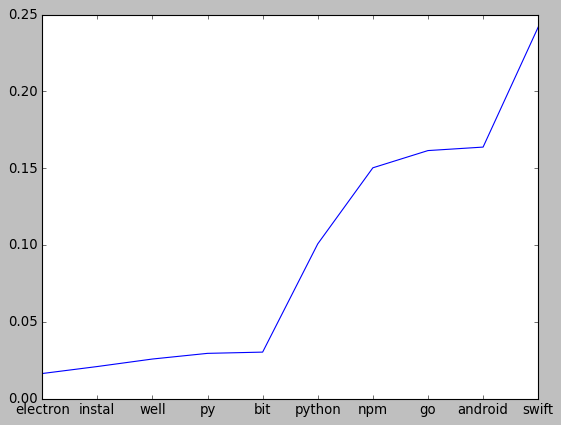

In [21]:
pd.Series(dict(zip(cv.get_feature_names(), tree.feature_importances_))).sort_values().tail(10).plot()

In [42]:
plt.rcParams['figure.figsize'] = (8,8)
cmap_train, cmap_test = "bone", "plasma"

## Classification

In [2]:
df = pd.read_csv('data/processed.csv')
X_train, X_test, y_train, y_test = train_test_split(df.readme, df.language,
                    test_size=.22, random_state=0, stratify=df.language)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   repo       701 non-null    object
 1   language   701 non-null    object
 2   readme     701 non-null    object
 3   words      701 non-null    int64 
 4   lang_freq  701 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 27.5+ KB
None


In [69]:
pd.DataFrame(df.language.value_counts())

,language
Go,106
Python,102
Java,102
C++,100
Swift,100
JavaScript,97
C,94


In [83]:
def report_and_conf_matrix(clf, X, y, cmap=cmap_train):
    scores = cross_val_score(estimator=clf, X=X, y=y)
    moments = [scores.mean(), scores.std()]
    print("-------MAXIMIZE THIS-------\nCross-validation mean accuracy: %0.3f (stdev %0.3f)\n---------------------------" % (moments[0], moments[1]))
    print(np.round(scores,3))
    print(classification_report(y, clf.predict(X)))
    plot_confusion_matrix(clf, X, y, values_format='.0f', cmap=cmap)
    return moments

### Dummy (baseline)

-------MAXIMIZE THIS-------
Cross-validation mean accuracy: 0.135 (stdev 0.018)
---------------------------
[0.155 0.138 0.11  0.156 0.119]
              precision    recall  f1-score   support

           C       0.11      0.12      0.12        73
         C++       0.13      0.12      0.12        78
          Go       0.21      0.22      0.22        83
        Java       0.14      0.13      0.13        79
  JavaScript       0.19      0.17      0.18        76
      Python       0.11      0.13      0.12        79
       Swift       0.18      0.19      0.19        78

    accuracy                           0.15       546
   macro avg       0.15      0.15      0.15       546
weighted avg       0.16      0.15      0.15       546



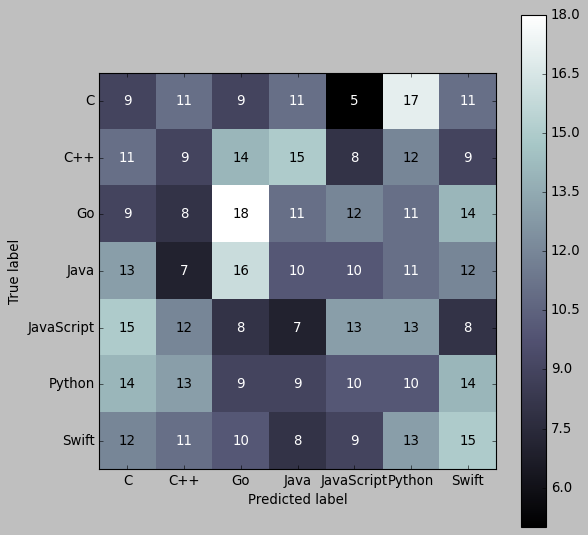

In [87]:
clf = DummyClassifier(strategy='stratified', random_state=2)
clf.fit(X_train, y_train)
clfmom = report_and_conf_matrix(clf, X=X_train, y=y_train)

### Naive Bayes

-------MAXIMIZE THIS-------
Cross-validation mean accuracy: 0.535 (stdev 0.020)
---------------------------
[0.509 0.541 0.523 0.532 0.569]
              precision    recall  f1-score   support

           C       0.92      0.99      0.95        73
         C++       1.00      0.92      0.96        78
          Go       0.99      1.00      0.99        83
        Java       0.98      1.00      0.99        79
  JavaScript       0.97      0.97      0.97        76
      Python       1.00      0.99      0.99        79
       Swift       1.00      0.99      0.99        78

    accuracy                           0.98       546
   macro avg       0.98      0.98      0.98       546
weighted avg       0.98      0.98      0.98       546



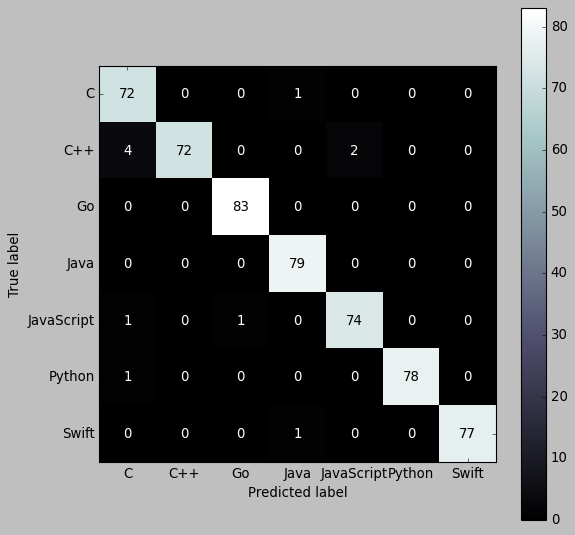

In [88]:
nb_clf = GaussianNB()
nb_vec = TfidfVectorizer(max_features=800)
X = nb_vec.fit_transform(X_train)
nb_clf.fit(X.todense(), y_train)
nbmom = report_and_conf_matrix(nb_clf, X=X.todense(), y=y_train)

### Logistic regression

-------MAXIMIZE THIS-------
Cross-validation mean accuracy: 0.729 (stdev 0.037)
---------------------------
[0.782 0.752 0.697 0.734 0.679]
              precision    recall  f1-score   support

           C       0.93      0.88      0.90        73
         C++       0.88      0.86      0.87        78
          Go       0.90      0.98      0.94        83
        Java       0.94      0.95      0.94        79
  JavaScript       0.92      0.89      0.91        76
      Python       0.90      0.92      0.91        79
       Swift       1.00      0.97      0.99        78

    accuracy                           0.92       546
   macro avg       0.92      0.92      0.92       546
weighted avg       0.92      0.92      0.92       546



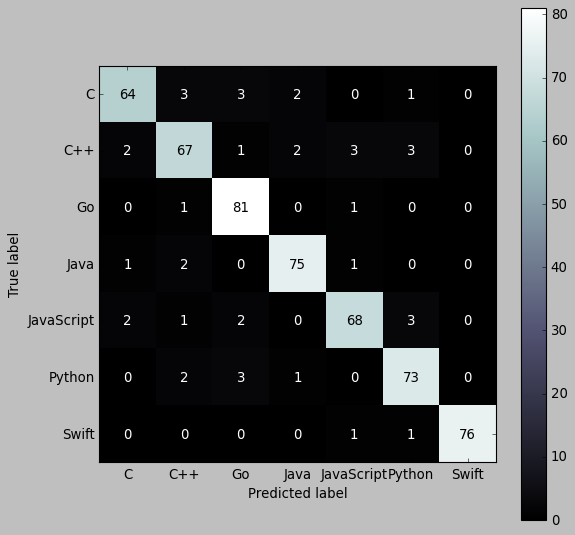

In [101]:
lr_clf = LogisticRegression(C=1)
lr_vec = TfidfVectorizer(min_df=40, max_df=.4)
X = lr_vec.fit_transform(X_train)
lr_clf.fit(X, y_train)
lrmom = report_and_conf_matrix(lr_clf, X=X, y=y_train)

In [102]:
eli5.explain_weights(lr_clf, feature_names=list(lr_vec.vocabulary_.keys()))

Explanation(estimator="LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n                   intercept_scaling=1, l1_ratio=None, max_iter=100,\n                   multi_class='auto', n_jobs=None, penalty='l2',\n                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,\n                   warm_start=False)", description="\nFeatures with largest coefficients per class.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='C', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='warn', weight=1.0217708580480989, std=None, value=None), FeatureWeight(feature='solut', weight=1.0191281428051784, std=None, value=None), FeatureWeight(feature='blue', weight=0.9836053114260256, std=None, value=None), FeatureWeight(feature='machin', weight=0.9012385417343652, std=None, value=None), FeatureWeight(feature='campaign', weight=0.8996892502442178, std=None, value=None), FeatureWeight(feature='privat', weight=0.8959815544647518, std=None, value=None), FeatureWeight(feature='content', weight=0.8452686605647134, std=None, value=None), FeatureWeight(feature='name', weight=0.7908350988631357, std=None, value=None), FeatureWeight(feature='password', weight=0.7387949993366895, std=None, value=None), FeatureWeight(feature='push', weight=0.7314421057244558, std=None, value=None), FeatureWeight(feature='overrid', weight=0.7024947422267714, std=None, value=None), FeatureWeight(feature='ignor', weight=0.6562983923704542, std=None, value=None), FeatureWeight(feature='rang', weight=0.6488291683640506, std=None, value=None), FeatureWeight(feature='valu', weight=0.6448420033712945, std=None, value=None), FeatureWeight(feature='second', weight=0.6291762579125951, std=None, value=None), FeatureWeight(feature='stream', weight=0.6274965001421524, std=None, value=None)], neg=[FeatureWeight(feature='buffer', weight=-1.0164938495487823, std=None, value=None), FeatureWeight(feature='associ', weight=-0.9551774537817042, std=None, value=None), FeatureWeight(feature='gitter', weight=-0.905881073380091, std=None, value=None), FeatureWeight(feature='consist', weight=-0.6300723117866206, std=None, value=None)], pos_remaining=359, neg_remaining=361), proba=None, score=None, weighted_spans=None, heatmap=None), TargetExplanation(target='C++', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='qualiti', weight=0.8885445343580365, std=None, value=None), FeatureWeight(feature='descript', weight=0.8788685816069988, std=None, value=None), FeatureWeight(feature='super', weight=0.8334507409995248, std=None, value=None), FeatureWeight(feature='interfac', weight=0.8236784170678603, std=None, value=None), FeatureWeight(feature='bind', weight=0.7991315712822001, std=None, value=None), FeatureWeight(feature='content', weight=0.7456802851829455, std=None, value=None), FeatureWeight(feature='multi', weight=0.7325202434483556, std=None, value=None), FeatureWeight(feature='templat', weight=0.7269023890077186, std=None, value=None), FeatureWeight(feature='js', weight=0.7203258295335287, std=None, value=None), FeatureWeight(feature='fork', weight=0.7197856257653046, std=None, value=None), FeatureWeight(feature='short', weight=0.7143796975092427, std=None, value=None), FeatureWeight(feature='introduct', weight=0.6847139074543631, std=None, value=None), FeatureWeight(feature='campaign', weight=0.6665036914554469, std=None, value=None), FeatureWeight(feature='close', weight=0.6662802935715062, std=None, value=None), FeatureWeight(feature='etc', weight=0.6

### kNN

-------MAXIMIZE THIS-------
Cross-validation mean accuracy: 0.658 (stdev 0.040)
---------------------------
[0.655 0.725 0.633 0.67  0.606]
              precision    recall  f1-score   support

           C       0.55      0.49      0.52        73
         C++       0.55      0.45      0.49        78
          Go       0.66      0.78      0.71        83
        Java       0.74      0.89      0.81        79
  JavaScript       0.73      0.72      0.73        76
      Python       0.73      0.66      0.69        79
       Swift       0.88      0.87      0.88        78

    accuracy                           0.70       546
   macro avg       0.69      0.69      0.69       546
weighted avg       0.69      0.70      0.69       546



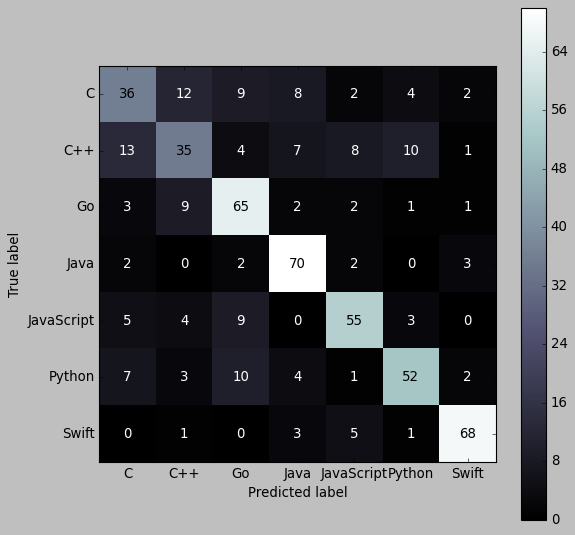

In [90]:
knn_clf = KNeighborsClassifier(n_neighbors=13)
knn_vec = TfidfVectorizer(min_df=25, max_df=.35)
X = knn_vec.fit_transform(X_train)
knn_clf.fit(X, y_train)
knnmom = report_and_conf_matrix(knn_clf, X=X, y=y_train)

### Random forest

-------MAXIMIZE THIS-------
Cross-validation mean accuracy: 0.775 (stdev 0.029)
---------------------------
[0.782 0.78  0.771 0.817 0.725]
              precision    recall  f1-score   support

           C       0.99      1.00      0.99        73
         C++       1.00      1.00      1.00        78
          Go       1.00      1.00      1.00        83
        Java       1.00      1.00      1.00        79
  JavaScript       1.00      1.00      1.00        76
      Python       1.00      0.99      0.99        79
       Swift       1.00      1.00      1.00        78

    accuracy                           1.00       546
   macro avg       1.00      1.00      1.00       546
weighted avg       1.00      1.00      1.00       546



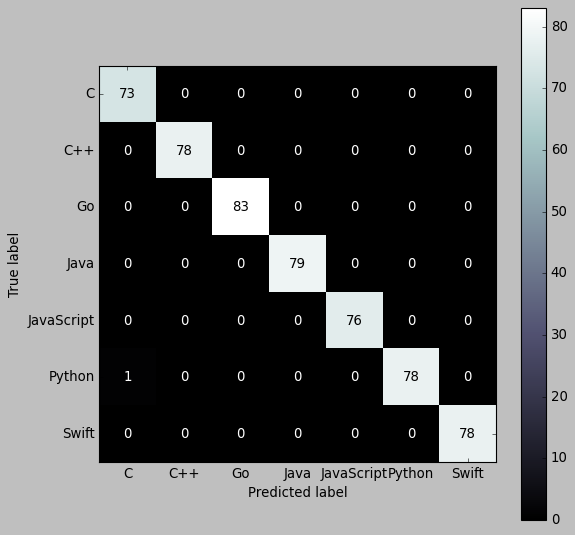

In [91]:
rf_clf = RandomForestClassifier(n_estimators=125,
                                max_depth=20,
                                random_state=36)
rf_vec = TfidfVectorizer(min_df=15, max_df=.35)
X = rf_vec.fit_transform(X_train)
rf_clf.fit(X, y_train)
rfmom = report_and_conf_matrix(rf_clf, X=X, y=y_train)

In [56]:
random_grid = {'n_estimators': [100, 200, 400],
               'max_depth': [20, 40, 60],
               'min_samples_split': [4, 5, 16],
               'min_samples_leaf': [2, 4, 8]}
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(),
                               param_distributions = random_grid,
                               n_iter = 20, cv = 3, verbose=2,
                               random_state=36, n_jobs = -1)
rf_random.fit(X, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   26.7s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [57]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_depth': 60}

In [66]:
eli5.explain_weights(rf_clf, feature_names=list(rf_vec.vocabulary_.keys()))

Weight,Feature
0.0253 ± 0.0681,core
0.0203 ± 0.0703,rout
0.0201 ± 0.0635,account
0.0164 ± 0.0614,boolean
0.0162 ± 0.0708,social
0.0158 ± 0.0522,proper
0.0148 ± 0.0484,round
0.0133 ± 0.0550,line
0.0132 ± 0.0472,mark
0.0125 ± 0.0467,dictionari


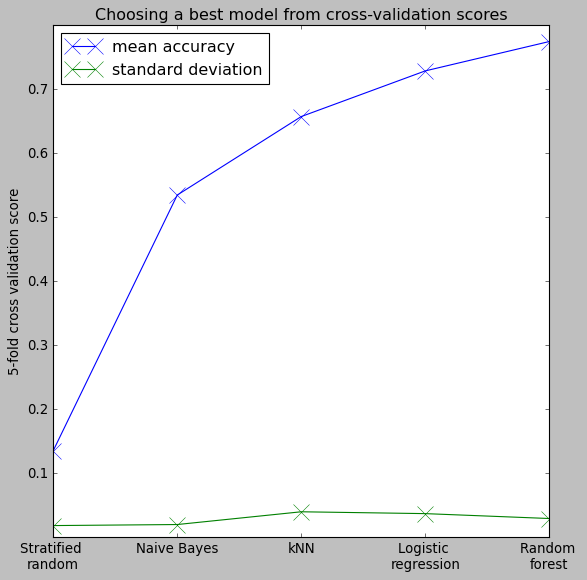

In [157]:
f, ax = plt.subplots()
plt.plot([clfmom, nbmom, knnmom, lrmom, rfmom], marker='x', ms=15)
plt.legend(["mean accuracy", "standard deviation"], loc='best')
ax.set_xticks(range(5))
ax.set_yticks([.1, .2, .3, .4, .5 , .6, .7])
ax.set_xticklabels(['Stratified \nrandom','Naive Bayes','kNN','Logistic \nregression','Random \nforest'])
plt.ylabel('5-fold cross validation score')
plt.title('Choosing a best model from cross-validation scores')
plt.savefig('img/cvscores.png')
plt.show()

### Test set

              precision    recall  f1-score   support

           C       0.57      0.57      0.57        21
         C++       0.67      0.45      0.54        22
          Go       0.91      0.87      0.89        23
        Java       0.71      0.87      0.78        23
  JavaScript       0.86      0.86      0.86        21
      Python       0.62      0.70      0.65        23
       Swift       0.95      0.95      0.95        22

    accuracy                           0.75       155
   macro avg       0.76      0.75      0.75       155
weighted avg       0.76      0.75      0.75       155



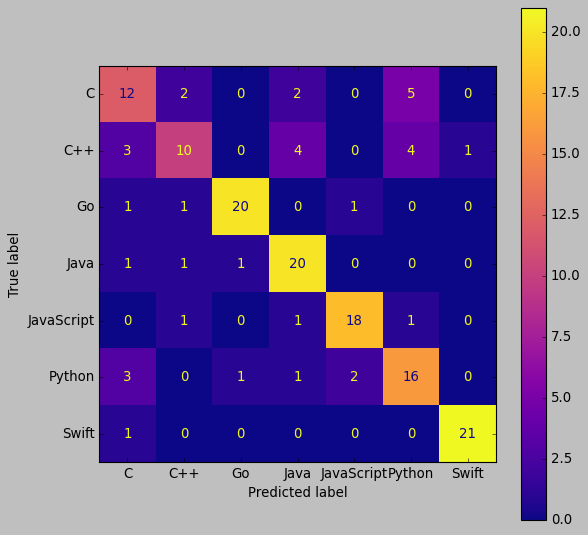

In [161]:
X = TfidfVectorizer(vocabulary=rf_vec.vocabulary_).fit_transform(X_test)
print(classification_report(y_test, rf_clf.predict(X)))
plot_confusion_matrix(rf_clf, X, y_test, cmap=cmap_test)
plt.savefig('img/rf_confmat.png')

-------MAXIMIZE THIS-------
Cross-validation mean accuracy: 0.129 (stdev 0.054)
---------------------------
[0.129 0.161 0.129 0.032 0.194]
              precision    recall  f1-score   support

           C       0.17      0.19      0.18        21
         C++       0.08      0.09      0.09        22
          Go       0.23      0.13      0.17        23
        Java       0.00      0.00      0.00        23
  JavaScript       0.20      0.24      0.22        21
      Python       0.07      0.09      0.08        23
       Swift       0.14      0.14      0.14        22

    accuracy                           0.12       155
   macro avg       0.13      0.12      0.12       155
weighted avg       0.13      0.12      0.12       155



[0.1290322580645161, 0.05397806622800488]

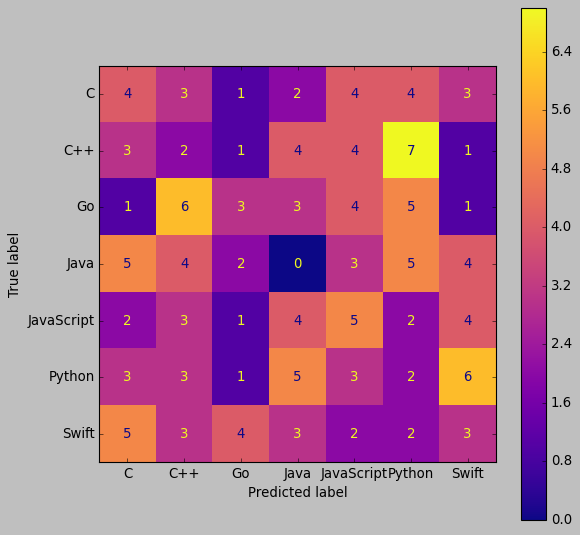

In [162]:
#dummy classifier
report_and_conf_matrix(clf, X=X, y=y_test, cmap=cmap_test)

# Big Takeaways:
> - 7 coding languages identified
> - Baseline Random 13.5%
> - (Best Model) Random Forest Depth 20 
> - Accuracy of  77.5%


<img src="img/languages.png" width="800"/>